# Import Libraries

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # Prevent incompatible gpu

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-07-21 17:06:51.744934: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 17:06:51.753832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753088811.763386  251493 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753088811.766221  251493 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753088811.774359  251493 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Exploratory Data Analysis

In [3]:
ROOT = "../../datasets/"
SEED = 88
IMG_SIZE = (224, 224)    # load at original size first
BATCH_SIZE = 256
LABEL_MODE = "categorical" # one‑hot labels straight away

classes=["broccoli", "cauliflower", "unknown"]
splits=["test", "train", "validate"]

def load_split(split):
    dataset=tf.keras.preprocessing.image_dataset_from_directory(ROOT+split,
        seed        = SEED,
        image_size  = IMG_SIZE,
        batch_size  = BATCH_SIZE,
        label_mode  = LABEL_MODE)
    return dataset

train_ds_pre = load_split("train")
val_ds_pre = load_split("validate")
test_ds_pre = load_split("test")

Found 7004 files belonging to 3 classes.
Found 859 files belonging to 3 classes.
Found 860 files belonging to 3 classes.


2025-07-21 17:06:53.692708: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


,broccoli,cauliflower,unknown,splits total
test,311,299,250,860
train,2595,2407,2002,7004
validate,311,298,250,859
img total,3217,3004,2502,8723


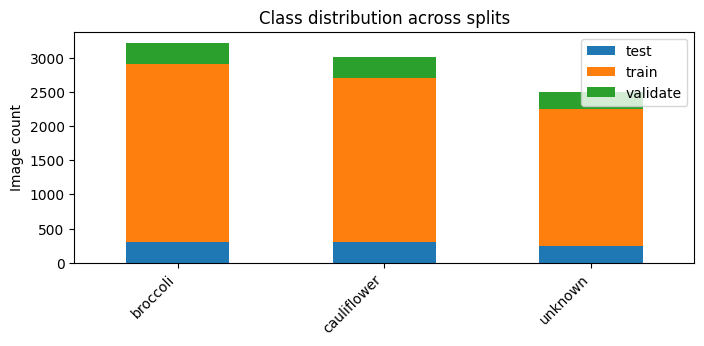

In [4]:
def count_images(split):
    return {cls: len(os.listdir(f"{ROOT}{split}/{cls}/"))
            for cls in classes}

df_counts = pd.DataFrame({s: count_images(s) for s in splits})

table_df = df_counts.T
table_df["splits total"] = table_df.sum(1)
table_df.loc["img total"] = table_df.sum(0)

display(table_df)  # Jupyter table

ax = df_counts.plot.bar(stacked=True, figsize=(8,3))
ax.set_title("Class distribution across splits")
ax.set_ylabel("Image count")
plt.xticks(rotation=45, ha="right")
plt.show()

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-21 17:06:54.595782: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


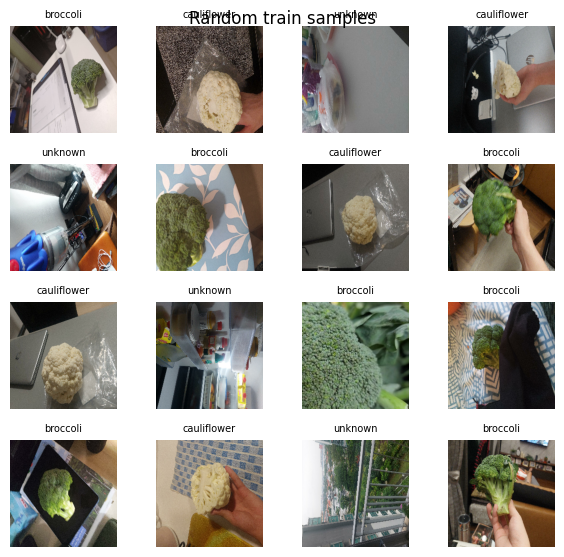

In [5]:
plt.figure(figsize=(6,6))
for images, labels in train_ds_pre.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")
plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [6]:
TARGET_SIZE = 100

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(TARGET_SIZE, TARGET_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomZoom((0.3), 0.3),
    layers.RandomBrightness(0.2, value_range=(0, 1)),
    layers.RandomErasing(0.3, value_range=(0, 1))
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds_pre, shuffle=True, augment=True)
val_ds = prepare(val_ds_pre)
test_ds = prepare(test_ds_pre)

2025-07-21 17:07:05.346789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 21 of 1000
2025-07-21 17:07:08.224033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-21 17:07:09.136495: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-07-21 17:07:09.136591: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-07-21 17:07:09.558475: I tensorfl

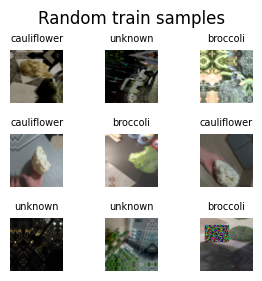

In [7]:
plt.figure(figsize=(3,3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")

plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Model building

In [8]:
num_classes = 3

model = keras.Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation="relu",
                 input_shape=(TARGET_SIZE, TARGET_SIZE,3)))

model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D((2,2)))   # 50→25
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))

model.add(layers.Conv2D(256, (3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D((2,2)))   # 12→6
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(512, (3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D((2,2)))   # 12→6
model.add(layers.Dropout(0.3))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(num_classes, activation="softmax"))

model.summary()

Optimizer = optimizers.AdamW(0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Optimizer,
              metrics=['accuracy'])


/home/me/anaconda3/envs/HELP/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,605,763 (6.13 MB)

 Trainable params: 1,605,763 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [10]:
history = model.fit(
    train_ds,
    epochs=100,
    verbose=1,
    validation_data = val_ds,
    callbacks=[early_stop]
)

score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


model.save_weights("model.weights.h5")
model.save("model.hdf5")

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.3664 - loss: 1.0937 - val_accuracy: 0.4831 - val_loss: 0.9877
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.4682 - loss: 0.9932 - val_accuracy: 0.6042 - val_loss: 0.8474
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.6111 - loss: 0.8932 - val_accuracy: 0.7846 - val_loss: 0.6644
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.7151 - loss: 0.7662 - val_accuracy: 0.7730 - val_loss: 0.6657
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.7490 - loss: 0.6765 - val_accuracy: 0.8114 - val_loss: 0.5351
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.7870 - loss: 0.5907 - val_accuracy: 0.8335 - val_loss: 0.4998
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - accuracy: 0.7791 - loss: 0.5953 - val_accuracy: 0.8510 - val_loss: 0.3867
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.8087 - loss: 0.4973 - val_accuracy: 0.

# Model Evalutation

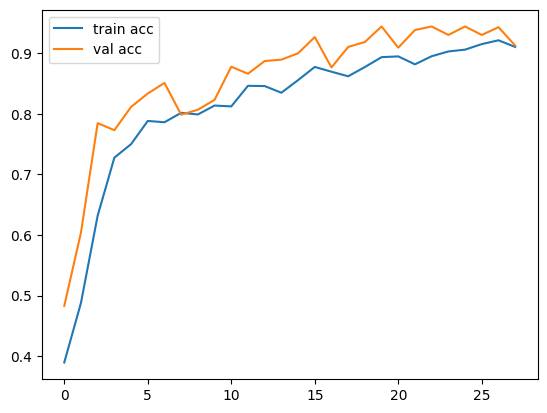

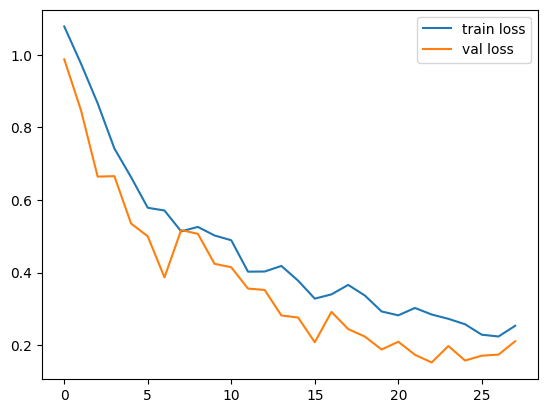

In [11]:
pd.DataFrame(history.history).to_csv("hist.csv", index=False)

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


1/8 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


2/8 ━━━━━━━━━━━━━━━━━━━━ 2s 387ms/step

Invalid SOS parameters for sequential JPEG


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Broccoli Precision:  0.9678456591639871
Broccoli Recall :  0.9647435897435898

Cauliflower Precision:  0.9732441471571907
Cauliflower Recall:  0.9509803921568627

Unknown Precision:  0.912
Unknown Recall:  0.9421487603305785


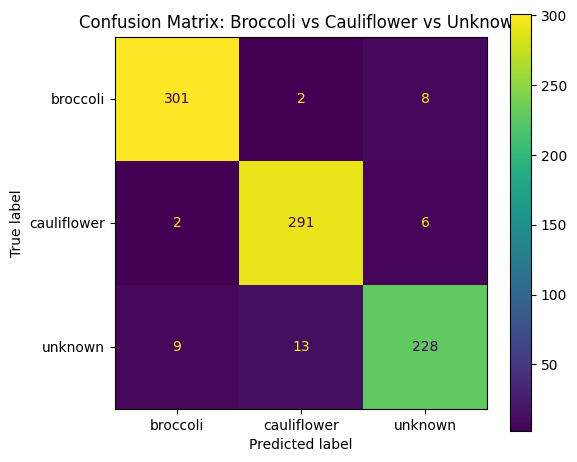

In [12]:
model = tf.keras.models.load_model('./model.hdf5')

y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = np.argmax(tf.concat([item for item in y_true], axis = 0), axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = confusion_matrix(correct_labels, predicted_labels)
print("Broccoli Precision: ", cm[0][0] / cm[0].sum())
print("Broccoli Recall : ", cm[0][0] / cm.T[0].sum())
print()
print("Cauliflower Precision: ", cm[1][1] / cm[1].sum())
print("Cauliflower Recall: ", cm[1][1] / cm.T[1].sum())
print()
print("Unknown Precision: ", cm[2][2] / cm[2].sum())
print("Unknown Recall: ", cm[2][2] / cm.T[2].sum())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax)
plt.title('Confusion Matrix: Broccoli vs Cauliflower vs Unknown')
plt.tight_layout()
plt.show()